<a href="https://colab.research.google.com/github/ParhamAbdarzade/Emotion-Classifier/blob/main/random_forest_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from urllib import request
import pandas as pd
import numpy as np
import pickle
import os

In [ ]:
class config:
  BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/"
  PROJ =  "emotion_clf/"
  DATA = BASE_PATH + PROJ + "dataset/" 
  MODEL = BASE_PATH + PROJ + "model/"
  RAW_DATA = DATA + 'raw_data.pkl'
  X = DATA + 'X_emotions.csv'
  y = DATA + 'Y_emotions.csv'
  rf_clf_30 = 'rf_clf_30.pkl'
  tf_idf_30 = 'tf_idf_30.pkl'

In [ ]:
X = pd.read_csv(config.X)
y = pd.read_csv(config.y)

In [ ]:
!wget https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl

--2022-11-14 20:26:29--  https://www.dropbox.com/s/607ptdakxuh5i4s/merged_training.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/607ptdakxuh5i4s/merged_training.pkl [following]
--2022-11-14 20:26:29--  https://www.dropbox.com/s/raw/607ptdakxuh5i4s/merged_training.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf49224e2b8f94cfaef5df9fb0e.dl.dropboxusercontent.com/cd/0/inline/Bwzv_5SpY_ARN6k4xS0-iOSLWFqah--LiyiSO51wVH_S4MR2FhP2ESz5QB1LvwgNIvkdMkpTCThP3HGYlbgSShKdSJp4WVCDe4Mm-tJJiMbjdYioyCBU_UTZeA1keVVaVhYLQiAmy6-MYkBw0bVTdVLfB59_xNca8NX7xh-9XgrOpw/file# [following]
--2022-11-14 20:26:29--  https://ucf49224e2b8f94cfaef5df9fb0e.dl.dropboxusercontent.com/cd/0/inline/Bwzv_5SpY_ARN6k4xS0-iOSLWFqah--LiyiSO51wVH_S4MR2FhP2ESz5QB1

In [ ]:
def save_object(obj, path, name):
  if not os.path.isdir(path):
      os.makedirs(path)
  with open(path + name, 'wb') as f:
    pickle.dump(obj, f)

def load_object(path):
  with open(path, 'rb') as f: 
    p = pickle.Unpickler(f) 
    data = p.load()
  return data

In [ ]:
data = load_object('merged_training.pkl')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416809 entries, 27383 to 64703
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   text      416809 non-null  object
 1   emotions  416809 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [ ]:
reseted_data = data.reset_index()

In [ ]:
reseted_data.head()

,index,text,emotions
0,27383,i feel awful about it too because it s my job ...,sadness
1,110083,im alone i feel awful,sadness
2,140764,ive probably mentioned this before but i reall...,joy
3,100071,i was feeling a little low few days back,sadness
4,2837,i beleive that i am much more sensitive to oth...,love


In [ ]:
reseted_data.pop('index')

0          27383
1         110083
2         140764
3         100071
4           2837
           ...  
416804       566
416805     36236
416806     76229
416807    131640
416808     64703
Name: index, Length: 416809, dtype: int64

In [ ]:
reseted_data.head()

,text,emotions
0,i feel awful about it too because it s my job ...,sadness
1,im alone i feel awful,sadness
2,ive probably mentioned this before but i reall...,joy
3,i was feeling a little low few days back,sadness
4,i beleive that i am much more sensitive to oth...,love


In [ ]:
data = reseted_data

In [ ]:
data.emotions.value_counts()

joy         141067
sadness     121187
anger        57317
fear         47712
love         34554
surprise     14972
Name: emotions, dtype: int64

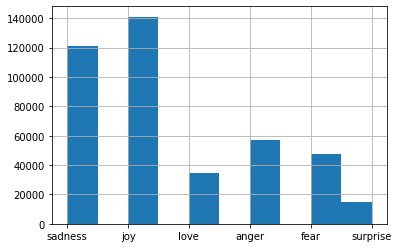

In [ ]:
data.emotions.hist()

In [ ]:
X = data.drop('emotions', axis = 1)
y = data.drop('text', axis = 1)

In [ ]:
X.to_csv(config.X, index = False)
y.to_csv(config.y, index = False)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

In [ ]:
class Population:
  def __init__(self, X_train, X_dev, X_test, y_train, y_test, y_dev):
     self.X_train, self.X_dev, self.X_test, self.y_train, self.y_test, self.y_dev =  X_train, X_dev, X_test, y_train, y_test, y_dev

In [ ]:
def train_dev_test_split(X, y):
  sss = StratifiedShuffleSplit(n_splits=10,test_size = 0.7 ,random_state=42)
  for train_index, r_index in sss.split(X, y):
    X_train, x_r = X.loc[train_index], X.loc[r_index]
    y_train, y_r = y.loc[train_index], y.loc[r_index]

  sss = StratifiedShuffleSplit(n_splits=10,test_size = 0.93 ,random_state=42)
  for dev_index, test_index in sss.split(x_r, y_r):
    X_dev, X_test = X.loc[dev_index], X.loc[test_index]
    y_dev, y_test = y.loc[dev_index], y.loc[test_index]
  
  return Population(X_train, X_dev, X_test, y_train, y_test, y_dev)


In [ ]:
pop = train_dev_test_split(X, y)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
class Stemmer(BaseEstimator, TransformerMixin):

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    stemmer = SnowballStemmer(language = 'english')
    transformedX = []
    for content in X['text'].values:
      s = [stemmer.stem(word) for word in word_tokenize(content)]
      transformedX.append(' '.join(s))
    X = X.drop('text', axis = 1)
    X['text'] = transformedX
    return X

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
class TfidfVectorizer_(BaseEstimator, TransformerMixin):
  def __init__(self, tf_idf_model = TfidfVectorizer()):
    self.tf_idf_model = tf_idf_model
    
  def fit(self, X, y=None):
    return self.tf_idf_model.fit(X['text'])

  def transform(self, X, y=None):
    return self.tf_idf_model.transform(X['text'])

  def fit_transform(self, X, y=None, **fit_params):
    self.fit(X)
    return self.transform(X)

In [ ]:
y_cats = np.unique(pop.y_train['emotions'])

In [ ]:
X_pipline =  Pipeline([
    ('stemmer', Stemmer()),
    ('tf_idf_model', TfidfVectorizer_())
])

In [ ]:
X_train_prepared = X_pipline.fit_transform(pop.X_train)

In [ ]:
save_object(X_pipline['tf_idf_model'], config.MODEL, "tf_idf_30.pkl")


In [ ]:
X_train_prepared

<125042x28422 sparse matrix of type '<class 'numpy.float64'>'
	with 1939282 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
pop.y_train.values.reshape(-1,).shape

(125042,)

In [ ]:
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train_prepared, pop.y_train.values.reshape(-1,))

RandomForestClassifier(random_state=42)

In [ ]:
save_object(rf_clf, config.MODEL, config.rf_clf_30)

In [ ]:
y_pred = rf_clf.predict(X_train_prepared)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
cr = classification_report(pop.y_train['emotions'], y_pred, labels = y_cats)

In [ ]:
print(cr)

              precision    recall  f1-score   support

       anger       0.99      0.99      0.99     17195
        fear       0.98      0.97      0.98     14313
         joy       0.99      0.99      0.99     42320
        love       0.97      0.95      0.96     10366
     sadness       0.99      0.99      0.99     36356
    surprise       0.95      0.96      0.95      4492

    accuracy                           0.98    125042
   macro avg       0.98      0.97      0.98    125042
weighted avg       0.98      0.98      0.98    125042



In [ ]:
y_pred_dev = rf_clf.predict(X_pipline.transform(pop.X_dev))
cr_dev = classification_report(pop.y_train['emotions'], y_pred, labels = y_cats)
print(cr_dev)

              precision    recall  f1-score   support

       anger       0.99      0.99      0.99     17195
        fear       0.98      0.97      0.98     14313
         joy       0.99      0.99      0.99     42320
        love       0.97      0.95      0.96     10366
     sadness       0.99      0.99      0.99     36356
    surprise       0.95      0.96      0.95      4492

    accuracy                           0.98    125042
   macro avg       0.98      0.97      0.98    125042
weighted avg       0.98      0.98      0.98    125042



In [ ]:
test = pd.DataFrame([''] , columns = ['text'])

In [ ]:
rf_clf.predict(X_pipline.transform(test))

array(['joy'], dtype=object)

In [ ]:
X_pipline =  Pipeline([
    ('stemmer', Stemmer()),
    ('tf_idf_model', TfidfVectorizer_(load_object(config.MODEL + config.tf_idf_30)))
])

In [ ]:
rf_clf = load_object(config.MODEL + config.rf_clf_30)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
imp = rf_clf.feature_importances_

In [ ]:
type(imp)

numpy.ndarray

In [ ]:
len(imp[22:])

28400

In [ ]:
step = (imp.max() - imp.min()) / 100
features_short_x = np.arange(imp.min() ,imp.max() - step, step)

In [ ]:
imp.sort()

In [ ]:
imp_grouped = imp[22:].reshape(-1, 1).reshape(-1,100)

In [ ]:
imp_grouped.shape

(284, 100)

In [ ]:
imp_mean_grouped = imp_grouped.mean(axis = 1)
imp_mean_grouped.shape

(284,)

In [ ]:
imp_x_axis = imp_grouped[:, 0]


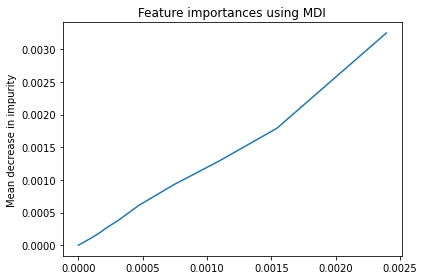

In [ ]:
fig, ax = plt.subplots()
ax.plot(imp_x_axis, imp_mean_grouped)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
imp = rf_clf.feature_importances_

In [ ]:
feature_imp = pd.Series(imp, index = range(0, len(imp)))

In [ ]:
top_1000_quantile = feature_imp.quantile(1 - 1000/len(feature_imp))

In [ ]:
top_1000_feature = feature_imp[lambda i: i >= top_1000_quantile]

In [ ]:
tf_idf_model = load_object(config.MODEL + config.tf_idf_30)

In [ ]:
vocab = tf_idf_model.tf_idf_model.vocabulary_

In [ ]:
type(vocab)

dict

In [ ]:
vocab_df = pd.Series(index = vocab.values(), data = vocab.keys(), )

In [ ]:
top_1000_vocab = vocab_df.iloc[top_1000_feature.index]

In [ ]:
top_1000_feature

56       0.000414
79       0.002812
97       0.000226
112      0.001725
133      0.002316
           ...   
28133    0.000116
28138    0.000157
28141    0.000476
28206    0.001809
28221    0.000748
Length: 1000, dtype: float64

In [ ]:
vocab_df.index

Int64Index([ 8496,  7504, 27288, 24844, 23625, 14594, 23528, 11306,   862,
             5595,
            ...
              467, 21399, 26544, 15977,  4111,  9431,  5235,  3305,  1169,
            12950],
           dtype='int64', length=28422)

In [ ]:
tf_idf_model.tf_idf_model.vocabulary_ = top_1000_vocab.values

In [ ]:
pipline = Pipeline([
    ('stemmer', Stemmer()),
    ('tf_idf_model', tf_idf_model)
])

In [ ]:
x_train_prepared = pipline.transform(pop.X_train)

IndexError: ignored